<a href="https://colab.research.google.com/github/Ananassio/Data-Minig-Lab/blob/main/Projekt/Projekt_Data_Minig_22_23_Marius_Zimmermann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import collections
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
!pip install tensorflow_addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# Daten import


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
GCS_PATH = 'drive/MyDrive/DataMinig/'

In [6]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [7]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [8]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [9]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [10]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

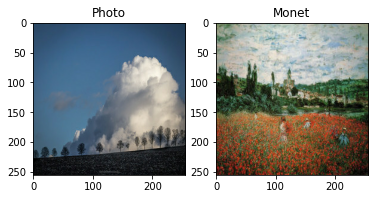

In [11]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

# Modelgenerierung

##Generator

In [12]:
def resblock(x, kernelsize, filters):
    fx = layers.Conv2D(filters, kernelsize, activation='relu', padding='same')(x)
    fx = layers.BatchNormalization()(fx)
    fx = layers.Conv2D(filters, kernelsize, padding='same')(fx)
    out = layers.Add()([x,fx])
    out = layers.ReLU()(out)
    out = layers.BatchNormalization()(out)
    return out

In [13]:
def Generator():

  inputs = layers.Input(shape=[256,256,3])

  # convolution layers
  l1 = layers.Conv2D(filters=64, kernel_size=(7,7), padding='same', strides=1, activation="relu")(inputs)
  l2 = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', strides=2, activation="relu")(l1)
  l3 = layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', strides=2, activation="relu")(l2)

  # residual blocks
  l4 = resblock(l3, (3,3), 256)
  l5 = resblock(l4, (3,3), 256)
  l6 = resblock(l5, (3,3), 256)
  l7 = resblock(l6, (3,3), 256)
  l8 = resblock(l7, (3,3), 256)
  l9 = resblock(l8, (3,3), 256)

  # transpose convolution layer
  l10 = layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), padding='same',strides=2, activation="relu")(l9)
  l11 = layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding='same',strides=2, activation="relu")(l10)

    # residual blocks
  l12 = resblock(l11, (3,3), 64)
  l13 = resblock(l12, (3,3), 64)
  l14 = resblock(l13, (3,3), 64)
  l15 = resblock(l14, (3,3), 64)
  l16 = resblock(l15, (3,3), 64)
  l17 = resblock(l16, (3,3), 64)

  l18 = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', strides=2, activation="relu")(l17)
  l19 = layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', strides=2, activation="relu")(l18)



  # residual blocks
  l20 = resblock(l19, (3,3), 256)
  l21 = resblock(l20, (3,3), 256)
  l22 = resblock(l21, (3,3), 256)
  l23 = resblock(l22, (3,3), 256)
  l24 = resblock(l23, (3,3), 256)
  l25 = resblock(l24, (3,3), 256)


  # transpose convolution layer
  l26 = layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), padding='same',strides=2, activation="relu")(l25)
  l27 = layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding='same',strides=2, activation="relu")(l26)
  l28 = layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), padding='same', activation="relu")(l27)
  # convolutional layer
  outputs = layers.Conv2D(filters=3, kernel_size=(3,3), padding='same', strides=1, activation="tanh")(l28)


  return keras.Model(inputs=inputs, outputs=outputs)

In [14]:
genout = Generator()
genout.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 12  73856       ['conv2d[0][0]']                 
                                8)                                                            

## Discriminator

In [15]:
def Discriminator():

  inputs = layers.Input(shape=[256,256,3])

  l1 = layers.Conv2D(filters=64, kernel_size=(4, 4), strides=2, activation="relu")(inputs)
  l2 = tfa.layers.InstanceNormalization(gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(l1)
  l3 = layers.LeakyReLU()(l2)

  l4 = layers.Conv2D(filters=128, kernel_size=(4, 4), strides=2, activation="relu")(l3)
  l5 = tfa.layers.InstanceNormalization(gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(l4)
  l6 = layers.LeakyReLU()(l5)

  l7 = layers.Conv2D(filters=256, kernel_size=(4, 4), strides=2, activation="relu")(l6)
  l8 = tfa.layers.InstanceNormalization(gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(l7)
  l9 = layers.LeakyReLU()(l8)

  l10 = layers.Conv2D(filters=512, kernel_size=(4, 4), strides=2, activation="relu")(l9)
  l11 = tfa.layers.InstanceNormalization(gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(l10)
  l12 = layers.LeakyReLU()(l11)

  outputs = layers.Conv2D(filters=1, kernel_size=(4, 4), strides=1, activation="sigmoid")(l9)

  return keras.Model(inputs=inputs, outputs=outputs)

In [16]:
disout = Discriminator()
disout.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_42 (Conv2D)          (None, 127, 127, 64)      3136      
                                                                 
 instance_normalization (Ins  (None, 127, 127, 64)     128       
 tanceNormalization)                                             
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 127, 127, 64)      0         
                                                                 
 conv2d_43 (Conv2D)          (None, 62, 62, 128)       131200    
                                                                 
 instance_normalization_1 (I  (None, 62, 62, 128)      256       
 nstanceNormalization)                                     

## Build the CycleGAN model

In [17]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [18]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## define loss functions

In [19]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [20]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [21]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [22]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

## train the cycle gan

In [24]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [25]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [28]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=10
)

Epoch 1/10
300/300 [==============================] - 373s 1s/step - monet_gen_loss: 9.4151 - photo_gen_loss: 9.4679 - monet_disc_loss: 0.4981 - photo_disc_loss: 0.5952
Epoch 2/10
300/300 [==============================] - 374s 1s/step - monet_gen_loss: 8.5585 - photo_gen_loss: 8.3535 - monet_disc_loss: 0.4745 - photo_disc_loss: 0.6225
Epoch 3/10
300/300 [==============================] - 374s 1s/step - monet_gen_loss: 8.0386 - photo_gen_loss: 7.8031 - monet_disc_loss: 0.4866 - photo_disc_loss: 0.6075
Epoch 4/10
300/300 [==============================] - 373s 1s/step - monet_gen_loss: 7.3372 - photo_gen_loss: 7.3638 - monet_disc_loss: 0.6011 - photo_disc_loss: 0.6181
Epoch 5/10
255/300 [========================>.....] - ETA: 56s - monet_gen_loss: 7.1839 - photo_gen_loss: 7.2467 - monet_disc_loss: 0.5931 - photo_disc_loss: 0.6133

KeyboardInterrupt: ignored

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(24, 24))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: ignored

## Create submission file

In [ ]:
import PIL
! mkdir ../images

In [ ]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")



In [35]:
pip install -U tensorflow_transform


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 439 kB 13.1 MB/s 
     |████████████████████████████████| 25.6 MB 1.3 MB/s 
     |████████████████████████████████| 14.5 MB 45.5 MB/s 
     |████████████████████████████████| 588.3 MB 21 kB/s 
     |████████████████████████████████| 21.6 MB 1.2 MB/s 
     |████████████████████████████████| 526 kB 75.7 MB/s 
     |████████████████████████████████| 62 kB 1.9 MB/s 
     |████████████████████████████████| 151 kB 82.2 MB/s 
     |████████████████████████████████| 2.5 MB 65.7 MB/s 
     |████████████████████████████████| 2.7 MB 20.6 MB/s 
     |████████████████████████████████| 278 kB 77.8 MB/s 
     |████████████████████████████████| 268 kB 75.4 MB/s 
     |████████████████████████████████| 435 kB 82.4 MB/s 
     |████████████████████████████████| 173 kB 56.5 MB/s 
     |████████████████████████████████| 294 kB 76.6 MB/s 
     |██████████████████████████

In [23]:
import tensorflow_transform as tft

In [25]:
import tensorflow_datasets as tfds

In [29]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [36]:
from sklearn.decomposition import PCA

## Eigenbilder berechnen

In [26]:
train_ds = monet_ds.unbatch()
images = list(train_ds)

In [57]:
new = np.empty((1,65536,3))
for i in range(300):
  temp = images[i][:,:,:].reshape(1,256*256,3)
  new = np.concatenate((new, temp), axis=0)

In [58]:
np.shape(new)

(301, 65536, 3)

In [59]:
new = np.delete(new, (0), axis=0)

In [60]:
np.shape(new)

(300, 65536, 3)

In [62]:
pca_r = PCA(whiten=True)
pca_r.fit(new[:,:,0])

pca_g = PCA(whiten=True)
pca_g.fit(new[:,:,1])

pca_b = PCA(whiten=True)
pca_b.fit(new[:,:,2])

PCA(whiten=True)

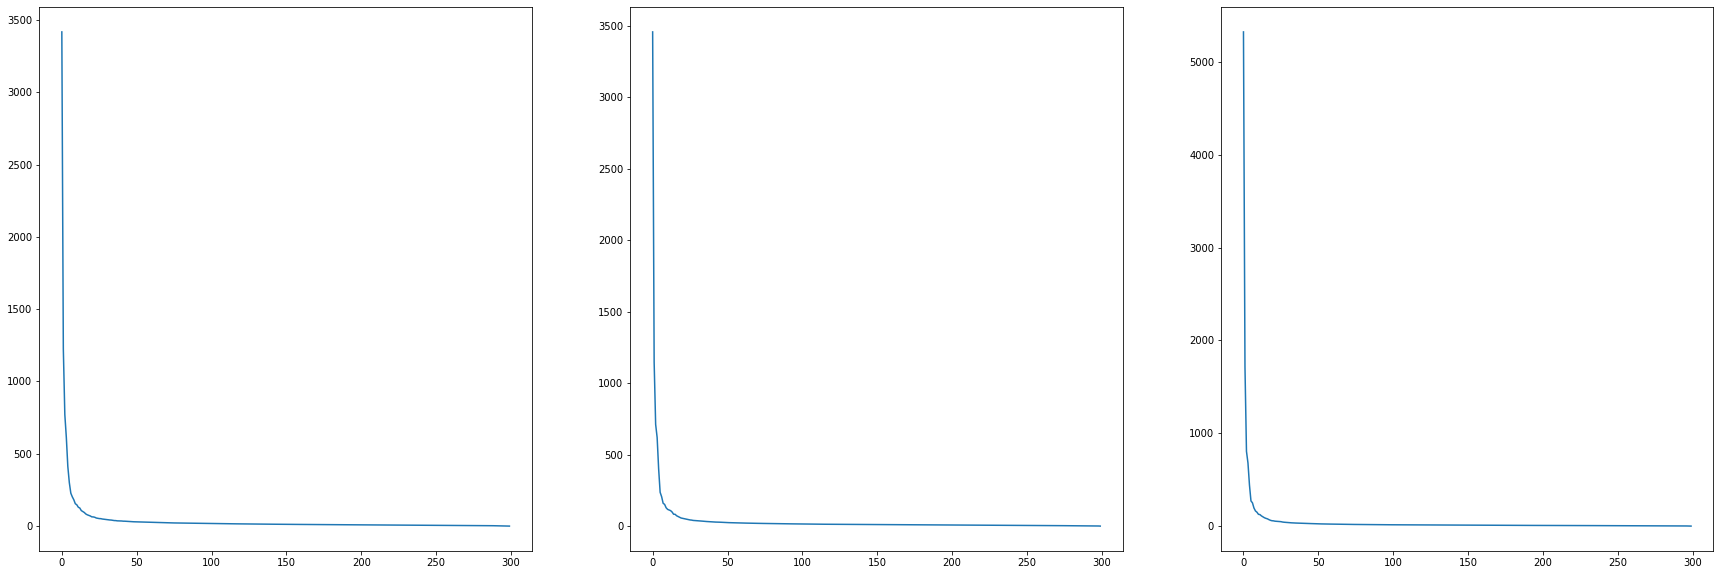

In [67]:
#plot Eigen-Values


fig, ax = plt.subplots(1, 3, figsize=(30,10))
ax[0].plot(pca_r.explained_variance_)
ax[1].plot(pca_g.explained_variance_)
ax[2].plot(pca_b.explained_variance_)

In [68]:
#fit the model angain and cut-off at 100
pca_r = PCA(n_components=50, whiten=True)
pca_r.fit(new[:,:,0])

pca_g = PCA(n_components=50, whiten=True)
pca_g.fit(new[:,:,1])

pca_b = PCA(n_components=50, whiten=True)
pca_b.fit(new[:,:,2])

PCA(n_components=50, whiten=True)

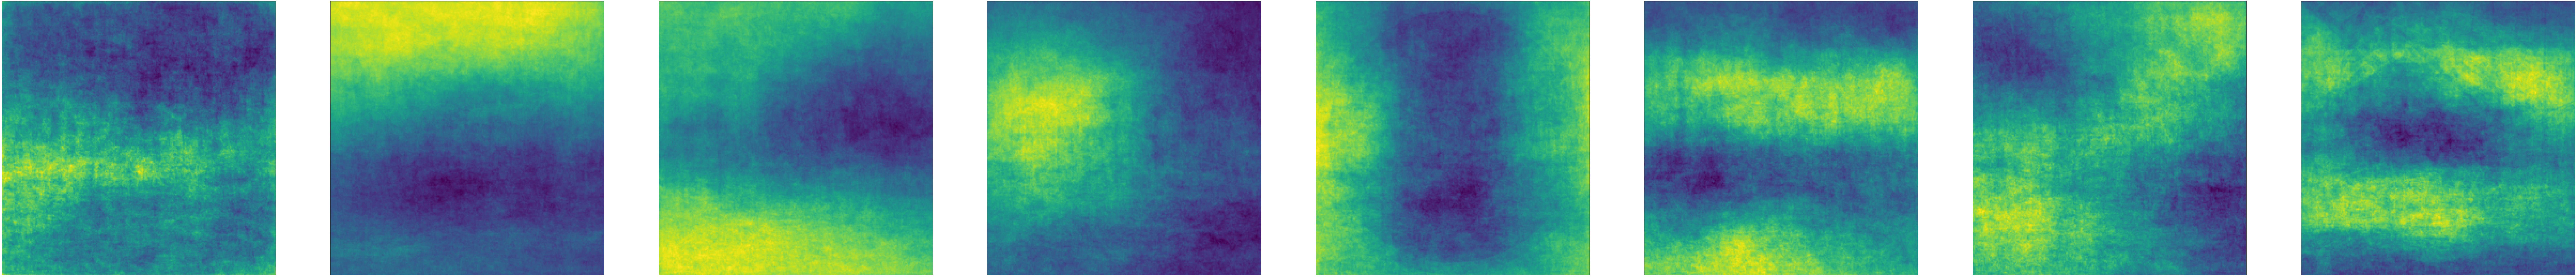

In [69]:
#have look at the first 8 Eigen-Vectors
fig, ax = plt.subplots(1, 8, figsize=(256,256))
for i in range(8):
    ax[i].imshow(pca_r.components_[i].reshape(256,256)* 0.5 + 0.5)
    ax[i].set_yticks([])
    ax[i].set_xticks([])

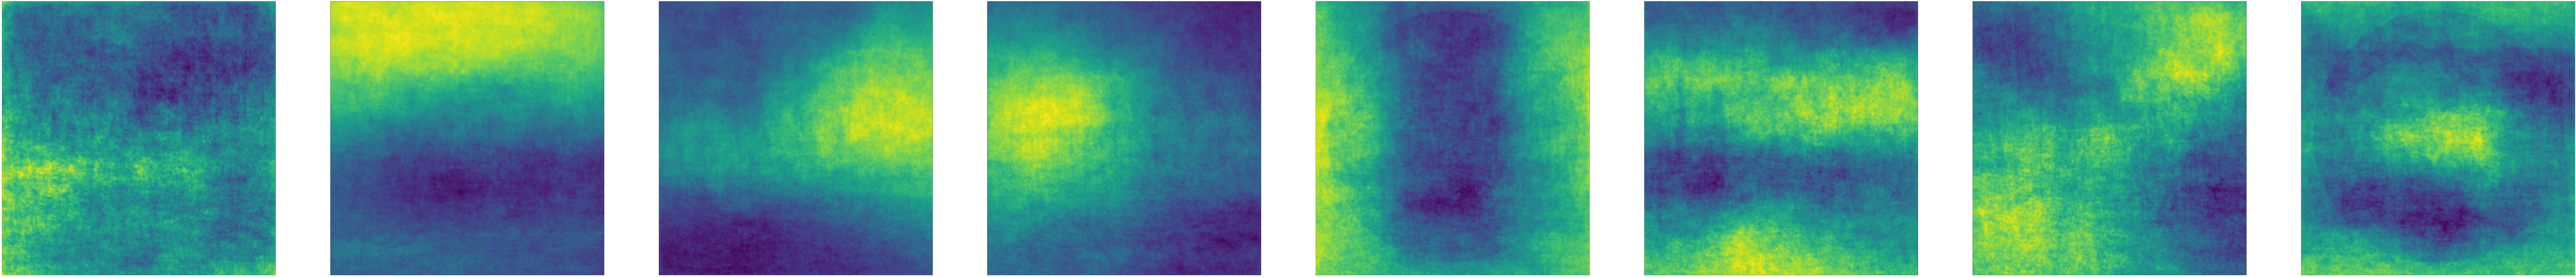

In [70]:
#have look at the first 8 Eigen-Vectors
fig, ax = plt.subplots(1, 8, figsize=(256,256))
for i in range(8):
    ax[i].imshow(pca_g.components_[i].reshape(256,256)* 0.5 + 0.5)
    ax[i].set_yticks([])
    ax[i].set_xticks([])

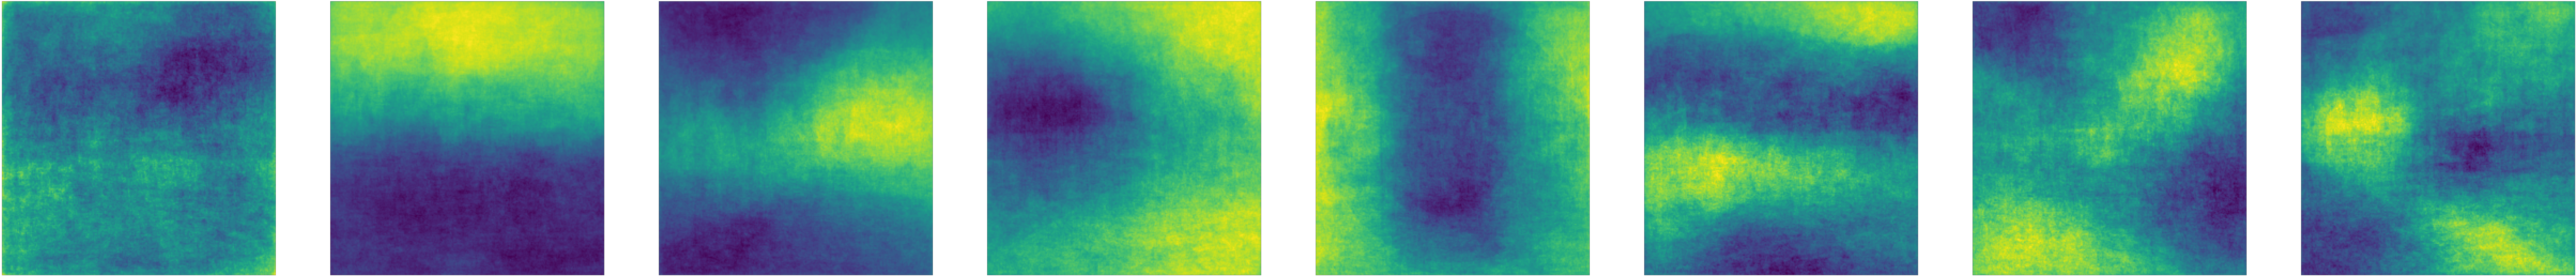

In [71]:
#have look at the first 8 Eigen-Vectors
fig, ax = plt.subplots(1, 8, figsize=(256,256))
for i in range(8):
    ax[i].imshow(pca_b.components_[i].reshape(256,256)* 0.5 + 0.5)
    ax[i].set_yticks([])
    ax[i].set_xticks([])

In [72]:
import cv2

In [86]:
img_reduced= (cv2.merge((pca_r.components_[0].reshape(256,256), pca_r.components_[1].reshape(256,256), pca_r.components_[2].reshape(256,256))))
print(img_reduced.shape)

(256, 256, 3)


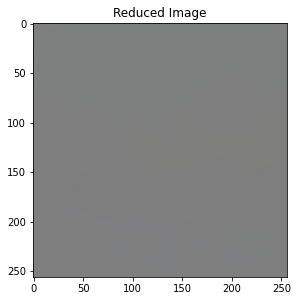

In [87]:
fig = plt.figure(figsize = (10, 7.2)) 
fig.add_subplot(122)
plt.title("Reduced Image")
plt.imshow(img_reduced* 0.5 + 0.5)
plt.show()

In [78]:
pca_r.components_[0]* 0.5 + 0.5

array([0.49863063, 0.49856968, 0.49852106, ..., 0.49868963, 0.49869427,
       0.49880113])